In [9]:
import numpy as np
import math
import random
from matplotlib import pyplot as plt
from statistics import mean
import scipy.special as sc

### Helper Functions

In [10]:
def Bernoulli_RV(p):
  X  = 0
  if random.random() < p:
    X = 1
  return X

def Beta(a,b):
  return sc.beta(a,b)


### Bernoulli Arm

In [14]:
class Bernoulli_Arm:
  def __init__(self,mean):
    self.mean = mean
    self.reward_list = []
    self.num_pulls = 0

  def step(self):
    reward  = Bernoulli_RV(self.mean)
    self.reward_list.append(reward)
    return reward
  
  def pull(self):
    self.num_pulls += 1

  def get_mean_reward(self):
    if len(self.reward_list) == 0:
      return 0
    return mean(self.reward_list)
  
  def get_num_pulls(self):
    return self.num_pulls


### The Queuing Bandit

In [15]:
class MAB:
  def __init__(self,num_arms,mean_list,arrival_rate):
    self.num_arms = num_arms
    self.arms = [Bernoulli_Arm(mean) for mean in mean_list]
    self.arrival_rate = arrival_rate
    self.queue_length = 0
    self.genie_queue_length = 0
    self.regret_list = []

  def step(self,arm_id):
    
    At = Bernoulli_RV(self.arrival_rate)
    rewards_list = [arm.step() for arm in self.arms]
    self.arms[arm_id].pull()
    St = rewards_list[arm_id]
    St_ = max(rewards_list)
    
    # the queue-length at time t
    self.queue_length = max(self.queue_length + At - St,0)
    self.genie_queue_length = max(self.queue_length + At - St_,0)
    
    # Regret = [Q(t) - Q*(t)]
    regret =  self.queue_length - self.genie_queue_length
    self.regret_list.append(regret)
    return St,regret

  def get_regret_list(self):
    return self.regret_list
  
  def get_best_arm(self):
    beta_list = []
    for arm in self.arms:
      emp_reward = arm.get_mean_reward()
      num_pulls = arm.get_num_pulls()
      beta_list.append(Beta((emp_reward*num_pulls)+1,((1-emp_reward)*num_pulls)+1))
    return np.array(beta_list).argmax()


### Q-ThS

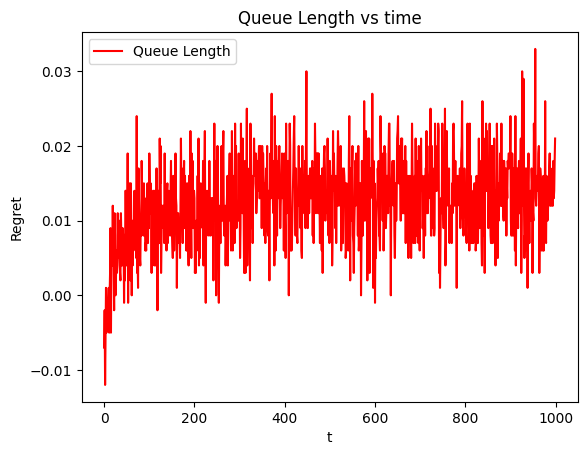

In [16]:
no_experiments = 100
time_horizon = 10000
K = 3
mean_list = [0.2,0.03,0.02]
arrival_rate = 0.1

mean_regret_list = np.array([0]*time_horizon)
for _ in range(no_experiments):
  mab = MAB(K,mean_list,arrival_rate)
  for i in range(time_horizon):
    t = i+1
    Et = min(1,3*K*(np.log(t)**2)/t)
    if Et == 1:
      chosen_arm = random.randrange(K)
      mab.step(chosen_arm)
    else :
      best_arm = mab.get_best_arm()
      mab.step(best_arm)
  mean_regret_list += np.array(mab.get_regret_list())
mean_regret_list = mean_regret_list/time_horizon

   
plt.title("Queue Length vs time")
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(range(time_horizon),mean_regret_list,color = 'red',label = 'Queue Length')
plt.legend()
plt.show()
